## 1. Installation

In [1]:
%%capture
import os, re

if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer einops addict easydict
!pip uninstall -y tensorflow protobuf
!pip install -q tensorflow protobuf 

## 2. Environment Setup (Colab / Kaggle)

In [2]:
# Mount Google Drive only for Colab
IS_KAGGLE = "KAGGLE_KERNEL_RUN_TYPE" in os.environ

if not IS_KAGGLE:
    print("\n📁 Mounting Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted!")
else:
    print("\n📁 Using Kaggle environment settings")
    print("✅ Kaggle input/output paths will be used")


📁 Using Kaggle environment settings
✅ Kaggle input/output paths will be used


## 3. Download and Load Model

In [3]:
from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "deepseek_ocr")

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README-checkpoint.md: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

'/kaggle/working/deepseek_ocr'

In [4]:
from unsloth import FastVisionModel
import torch
from transformers import AutoModel
import os

os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'

model, tokenizer = FastVisionModel.from_pretrained(
    "./deepseek_ocr",
    load_in_4bit = False,
    auto_model = AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.11/dist-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


🦥 Unsloth Zoo will now patch everything to make training faster!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.6: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at ./deepseek_ocr and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Download and Extract Dataset

**Colab:** Update `ZIP_PATH` to your Google Drive location

**Kaggle:** Add dataset to notebook, it will be available at `/kaggle/input/`

In [5]:
import zipfile
import json
from PIL import Image
from tqdm import tqdm

# Setup paths based on environment
if not IS_KAGGLE:
    # ⚠️ UPDATE THIS PATH TO YOUR ZIP FILE ON GOOGLE DRIVE
    ZIP_PATH = '/content/drive/MyDrive/UIT_HWDB_word.zip'
    EXTRACT_DIR = '/content/UIT_HWDB_word'
    
    print(f"📦 Colab: Extracting dataset from: {ZIP_PATH}")
    print(f"📂 Extracting to: {EXTRACT_DIR}")
    
    # Extract zip file
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    
    print(f"✅ Extraction complete!")
    
else:
    # Kaggle settings (or any non-Colab environment)
    # ⚠️ UPDATE 'your-dataset-name' to match your Kaggle dataset
    KAGGLE_INPUT = '/kaggle/input/uit-hwdb-word/UIT_HWDB_word'  # Change this to your dataset name
    
    # Check if zip file exists in Kaggle input
    if os.path.exists(KAGGLE_INPUT):
        zip_files = [f for f in os.listdir(KAGGLE_INPUT) if f.endswith('.zip')]
        
        if zip_files:
            # Extract from zip
            ZIP_PATH = os.path.join(KAGGLE_INPUT, zip_files[0])
            EXTRACT_DIR = '/kaggle/working/UIT_HWDB_word'
            
            print(f"📦 Kaggle: Extracting dataset from: {ZIP_PATH}")
            print(f"📂 Extracting to: {EXTRACT_DIR}")
            
            with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
                zip_ref.extractall('/kaggle/working/')
            
            print(f"✅ Extraction complete!")
        else:
            # Assume dataset is already extracted in Kaggle input
            EXTRACT_DIR = KAGGLE_INPUT
            print(f"📂 Kaggle: Using dataset from: {EXTRACT_DIR}")
    else:
        # Fallback to local path
        EXTRACT_DIR = '../data/UIT_HWDB_word'
        print(f"📂 Local: Using dataset from: {EXTRACT_DIR}")

# Set data directories
TRAIN_DIR = os.path.join(EXTRACT_DIR, 'train_data')
TEST_DIR = os.path.join(EXTRACT_DIR, 'test_data')

print(f"\n✓ Train directory: {TRAIN_DIR}")
print(f"✓ Train exists: {os.path.exists(TRAIN_DIR)}")
print(f"✓ Test directory: {TEST_DIR}")
print(f"✓ Test exists: {os.path.exists(TEST_DIR)}")

📂 Kaggle: Using dataset from: /kaggle/input/uit-hwdb-word/UIT_HWDB_word

✓ Train directory: /kaggle/input/uit-hwdb-word/UIT_HWDB_word/train_data
✓ Train exists: True
✓ Test directory: /kaggle/input/uit-hwdb-word/UIT_HWDB_word/test_data
✓ Test exists: True


## 5. Load and Preprocess Data

In [6]:
def load_dataset_from_folders(base_dir):
    """
    Load dataset from folder structure with label.json files.
    Converts to Deepseek OCR conversation format with PIL Image objects.

    Structure:
    base_dir/
        1/label.json + images
        2/label.json + images
        ...
    """
    conversations = []
    folders = sorted(
        [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))],
        key=lambda x: int(x)
    )

    instruction = "<image>\nFree OCR. "

    for folder in tqdm(folders, desc=f"Loading {os.path.basename(base_dir)}"):
        label_path = os.path.join(base_dir, folder, 'label.json')
        if not os.path.exists(label_path):
            continue

        # Load labels
        with open(label_path, 'r', encoding='utf-8') as f:
            labels = json.load(f)

        # Process each image
        for img_name, label in labels.items():
            img_path = os.path.join(base_dir, folder, img_name)
            if not os.path.exists(img_path):
                continue

            try:
                # Load image as PIL object (required by Deepseek OCR)
                image = Image.open(img_path).convert('RGB')

                # Create conversation format
                conversation = {
                    "messages": [
                        {
                            "role": "<|User|>",
                            "content": instruction,
                            "images": [image]  # PIL Image object
                        },
                        {
                            "role": "<|Assistant|>",
                            "content": label.strip()
                        }
                    ]
                }
                conversations.append(conversation)
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")

    return conversations

# Load datasets
print("\n📥 Loading training data...")
train_dataset = load_dataset_from_folders(TRAIN_DIR)
print(f"✅ Loaded {len(train_dataset):,} training samples")

print("\n📥 Loading test data...")
test_dataset = load_dataset_from_folders(TEST_DIR)
print(f"✅ Loaded {len(test_dataset):,} test samples")

print(f"\n📊 Total: {len(train_dataset) + len(test_dataset):,} samples")


📥 Loading training data...


Loading train_data: 100%|██████████| 249/249 [10:02<00:00,  2.42s/it]


✅ Loaded 107,607 training samples

📥 Loading test data...


Loading test_data: 100%|██████████| 6/6 [00:20<00:00,  3.43s/it]

✅ Loaded 2,881 test samples

📊 Total: 110,488 samples


In [7]:
# Verify data format
print("🔍 Verifying data structure:")
sample = train_dataset[0]
print(f"  ✓ Messages: {len(sample['messages'])}")
print(f"  ✓ User content: {sample['messages'][0]['content']}")
print(f"  ✓ Images: {len(sample['messages'][0]['images'])} PIL Image(s)")
print(f"  ✓ Image type: {type(sample['messages'][0]['images'][0])}")
print(f"  ✓ Image size: {sample['messages'][0]['images'][0].size}")
print(f"  ✓ Assistant content: '{sample['messages'][1]['content']}'")

🔍 Verifying data structure:
  ✓ Messages: 2
  ✓ User content: <image>
Free OCR. 
  ✓ Images: 1 PIL Image(s)
  ✓ Image type: <class 'PIL.Image.Image'>
  ✓ Image size: (128, 72)
  ✓ Assistant content: 'KHÁI'


## 6. (Optional) Test Baseline Model

Test the pretrained model before finetuning.

Ground truth: 'tiếng'


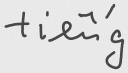

In [8]:
# Select a test sample
test_sample = test_dataset[50]
test_image = test_sample['messages'][0]['images'][0]
ground_truth = test_sample['messages'][1]['content']

# Save and display
test_image.save("test_image.jpg")
from IPython.display import display
print(f"Ground truth: '{ground_truth}'")
display(test_image)

In [9]:
# Run baseline inference
prompt = "<image>\nFree OCR. "
print("Running baseline model...")
res = model.infer(
    tokenizer,
    prompt=prompt,
    image_file='test_image.jpg',
    output_path='./output',
    base_size=1024,
    image_size=640,
    crop_mode=True,
    save_results=False,
    test_compress=False
)

Running baseline model...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tieg


---
## 7. Add LoRA Adapters

Parameter-efficient finetuning with LoRA - only train ~1% of parameters.

In [10]:
model = FastVisionModel.get_peft_model(
    model,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.model` require gradients


## 8. Prepare Training Dataset

Choose dataset size for training.

In [11]:
# Option 1: Full dataset (107K+ samples, takes longer)
converted_dataset = train_dataset

# Option 2: Subset for faster experimentation (uncomment below)
# converted_dataset = train_dataset[:5000]

print(f"🎯 Using {len(converted_dataset):,} samples for training")

# Verify format
sample = converted_dataset[0]
print(f"\n✓ Sample check:")
print(f"  Role: {sample['messages'][0]['role']}")
print(f"  Content: {sample['messages'][0]['content']}")
print(f"  Images: {type(sample['messages'][0]['images'][0])}")
print(f"  Label: '{sample['messages'][1]['content']}'")

🎯 Using 107,607 samples for training

✓ Sample check:
  Role: <|User|>
  Content: <image>
Free OCR. 
  Images: <class 'PIL.Image.Image'>
  Label: 'KHÁI'


## 9. Create Data Collator

This handles image preprocessing and batching for Deepseek OCR.

In [12]:
# @title DeepSeekOCRDataCollator

import torch
import math
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
import io

from deepseek_ocr.modeling_deepseekocr import (
    text_encode,
    BasicImageTransform,
    dynamic_preprocess,
)

@dataclass
class DeepSeekOCRDataCollator:
    tokenizer: Any
    model: Any
    image_size: int = 640
    base_size: int = 1024
    crop_mode: bool = True
    image_token_id: int = 128815
    train_on_responses_only: bool = True

    def __init__(self, tokenizer, model, image_size=640, base_size=1024,
                 crop_mode=True, train_on_responses_only=True):
        self.tokenizer = tokenizer
        self.model = model
        self.image_size = image_size
        self.base_size = base_size
        self.crop_mode = crop_mode
        self.image_token_id = 128815
        self.dtype = model.dtype
        self.train_on_responses_only = train_on_responses_only
        self.image_transform = BasicImageTransform(
            mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), normalize=True
        )
        self.patch_size = 16
        self.downsample_ratio = 4
        self.bos_id = tokenizer.bos_token_id if hasattr(tokenizer, 'bos_token_id') else 0

    def deserialize_image(self, image_data) -> Image.Image:
        if isinstance(image_data, Image.Image):
            return image_data.convert("RGB")
        elif isinstance(image_data, dict) and 'bytes' in image_data:
            return Image.open(io.BytesIO(image_data['bytes'])).convert("RGB")
        raise ValueError(f"Unsupported image format: {type(image_data)}")

    def process_image(self, image: Image.Image):
        images_list, images_crop_list, images_spatial_crop = [], [], []

        if self.crop_mode:
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = (1, 1)
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(
                    image, min_num=2, max_num=9, image_size=self.image_size, use_thumbnail=False
                )

            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color=tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))
            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])

            if width_crop_num > 1 or height_crop_num > 1:
                for crop_img in images_crop_raw:
                    images_crop_list.append(self.image_transform(crop_img).to(self.dtype))

            num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base + [self.image_token_id]

            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (num_queries * height_crop_num)
        else:
            crop_ratio = (1, 1)
            images_spatial_crop.append([1, 1])
            if self.base_size <= 640:
                resized_image = image.resize((self.base_size, self.base_size), Image.LANCZOS)
                images_list.append(self.image_transform(resized_image).to(self.dtype))
            else:
                global_view = ImageOps.pad(
                    image, (self.base_size, self.base_size),
                    color=tuple(int(x * 255) for x in self.image_transform.mean)
                )
                images_list.append(self.image_transform(global_view).to(self.dtype))

            num_queries = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries + [self.image_token_id]) * num_queries + [self.image_token_id]

        return images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio

    def process_single_sample(self, messages: List[Dict]):
        images = []
        for message in messages:
            if "images" in message and message["images"]:
                for img_data in message["images"]:
                    if img_data is not None:
                        images.append(self.deserialize_image(img_data))

        if not images:
            raise ValueError("No images found in sample")

        tokenized_str = [self.bos_id]
        images_seq_mask = [False]
        images_list, images_crop_list, images_spatial_crop = [], [], []
        prompt_token_count = -1
        assistant_started = False
        image_idx = 0

        for message in messages:
            role, content = message["role"], message["content"]

            if role == "<|Assistant|>":
                if not assistant_started:
                    prompt_token_count = len(tokenized_str)
                    assistant_started = True
                content = f"{content.strip()} {self.tokenizer.eos_token}"

            text_splits = content.split('<image>')
            for i, text_sep in enumerate(text_splits):
                tokenized_sep = text_encode(self.tokenizer, text_sep, bos=False, eos=False)
                tokenized_str.extend(tokenized_sep)
                images_seq_mask.extend([False] * len(tokenized_sep))

                if i < len(text_splits) - 1:
                    if image_idx >= len(images):
                        raise ValueError("Mismatch between <image> tokens and actual images")
                    img_list, crop_list, spatial_crop, tok_img, _ = self.process_image(images[image_idx])
                    images_list.extend(img_list)
                    images_crop_list.extend(crop_list)
                    images_spatial_crop.extend(spatial_crop)
                    tokenized_str.extend(tok_img)
                    images_seq_mask.extend([True] * len(tok_img))
                    image_idx += 1

        if not assistant_started:
            prompt_token_count = len(tokenized_str)

        images_ori = torch.stack(images_list, dim=0)
        images_spatial_crop_tensor = torch.tensor(images_spatial_crop, dtype=torch.long)
        images_crop = torch.stack(images_crop_list) if images_crop_list else torch.zeros((1, 3, self.base_size, self.base_size), dtype=self.dtype)

        return {
            "input_ids": torch.tensor(tokenized_str, dtype=torch.long),
            "images_seq_mask": torch.tensor(images_seq_mask, dtype=torch.bool),
            "images_ori": images_ori,
            "images_crop": images_crop,
            "images_spatial_crop": images_spatial_crop_tensor,
            "prompt_token_count": prompt_token_count,
        }

    def __call__(self, features: List[Dict[str, Any]]):
        batch_data = []
        for feature in features:
            try:
                batch_data.append(self.process_single_sample(feature['messages']))
            except Exception as e:
                print(f"Error: {e}")
                continue

        if not batch_data:
            raise ValueError("No valid samples in batch")

        input_ids = pad_sequence([item['input_ids'] for item in batch_data], batch_first=True, padding_value=self.tokenizer.pad_token_id)
        images_seq_mask = pad_sequence([item['images_seq_mask'] for item in batch_data], batch_first=True, padding_value=False)
        prompt_token_counts = [item['prompt_token_count'] for item in batch_data]

        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        labels[images_seq_mask] = -100

        if self.train_on_responses_only:
            for idx, prompt_count in enumerate(prompt_token_counts):
                if prompt_count > 0:
                    labels[idx, :prompt_count] = -100

        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()
        images_batch = [(item['images_crop'], item['images_ori']) for item in batch_data]
        images_spatial_crop = torch.cat([item['images_spatial_crop'] for item in batch_data], dim=0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "images": images_batch,
            "images_seq_mask": images_seq_mask,
            "images_spatial_crop": images_spatial_crop,
        }

## 10. Train the Model

Configure training parameters and start finetuning.

In [13]:
from transformers import Trainer, TrainingArguments
from unsloth import is_bf16_supported

FastVisionModel.for_training(model)

data_collator = DeepSeekOCRDataCollator(
    tokenizer=tokenizer,
    model=model,
    image_size=384,
    base_size=384,
    crop_mode=False,
    train_on_responses_only=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=converted_dataset,
    args=TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_steps=5,
        # max_steps=None,  # For quick test. Set num_train_epochs=1 and max_steps=None for full run
        num_train_epochs=2,
        learning_rate=1e-4,
        logging_steps=100,
        optim="adamw_8bit",
        weight_decay=0.001,
        lr_scheduler_type="linear",
        seed=3407,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        output_dir="outputs",
        report_to="none",
        dataloader_num_workers=8,
        remove_unused_columns=False,  # Required for vision models
    ),
)

/tmp/ipykernel_19/2388775256.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
# Check GPU memory before training
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU: {gpu_stats.name}, Max memory: {max_memory} GB")
print(f"Memory reserved: {start_gpu_memory} GB")

GPU: Tesla T4, Max memory: 14.741 GB
Memory reserved: 6.73 GB


In [15]:
# Start training
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 107,607 | Num Epochs = 2 | Total steps = 1,682
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 2 x 1) = 128
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)
Unsloth: Not an error, but DeepseekOCRForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
100,1.117200
200,0.373200
300,0.293800
400,0.243100
500,0.214300
600,0.199000
700,0.195300
800,0.168900
900,0.152300
1000,0.133100


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [16]:
# Show training stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"⏱️  Training time: {round(trainer_stats.metrics['train_runtime']/60, 2)} minutes")
print(f"💾 Peak memory: {used_memory} GB ({used_percentage}%)")
print(f"💾 Memory for LoRA: {used_memory_for_lora} GB ({lora_percentage}%)")

⏱️  Training time: 355.23 minutes
💾 Peak memory: 13.66 GB (92.667%)
💾 Memory for LoRA: 6.93 GB (47.012%)


## 11. Test Finetuned Model

In [17]:
# Test on same sample as baseline
print("Testing finetuned model...")
res = model.infer(
    tokenizer,
    prompt="<image>\nFree OCR. ",
    image_file='test_image.jpg',
    output_path='./output',
    image_size=640,
    base_size=1024,
    crop_mode=True,
    save_results=False
)

print(f"📝 Ground truth: '{ground_truth}'")

Testing finetuned model...
triển 
📝 Ground truth: 'tiếng'


## 12. Save Model

Save LoRA adapters (paths adjust based on environment).

In [18]:
# Setup save path based on environment
if not IS_KAGGLE:
    SAVE_PATH = "/content/drive/MyDrive/deepseek_ocr_lora"
    print(f"💾 Colab: Saving to Google Drive...")
else:
    SAVE_PATH = "/kaggle/working/deepseek_ocr_lora"
    print(f"💾 Kaggle: Saving to working directory...")

model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

print(f"✅ Model saved to: {SAVE_PATH}")

# Additional note for Kaggle users
if not IS_KAGGLE:
    print("\n📝 Note for Kaggle users:")
    print("   - Model saved to /kaggle/working/")
    print("   - Click 'Save Version' to persist the output")
    print("   - Or download the folder manually")

💾 Kaggle: Saving to working directory...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


✅ Model saved to: /kaggle/working/deepseek_ocr_lora


## 13. (Optional) Load Saved Model

Load the finetuned model for inference.

In [19]:
# Uncomment to load saved model
"""
from unsloth import FastVisionModel

model, tokenizer = FastVisionModel.from_pretrained(
    model_name=SAVE_PATH,
    load_in_4bit=False,
    auto_model=AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    use_gradient_checkpointing="unsloth",
)
FastVisionModel.for_inference(model)

# Run inference
res = model.infer(
    tokenizer,
    prompt="<image>\nFree OCR. ",
    image_file='test_image.jpg',
    output_path='./output',
    image_size=640,
    base_size=1024,
    crop_mode=True
)
print(f"Result: {res}")
"""

'\nfrom unsloth import FastVisionModel\n\nmodel, tokenizer = FastVisionModel.from_pretrained(\n    model_name=SAVE_PATH,\n    load_in_4bit=False,\n    auto_model=AutoModel,\n    trust_remote_code=True,\n    unsloth_force_compile=True,\n    use_gradient_checkpointing="unsloth",\n)\nFastVisionModel.for_inference(model)\n\n# Run inference\nres = model.infer(\n    tokenizer,\n    prompt="<image>\nFree OCR. ",\n    image_file=\'test_image.jpg\',\n    output_path=\'./output\',\n    image_size=640,\n    base_size=1024,\n    crop_mode=True\n)\nprint(f"Result: {res}")\n'

## 14. (Optional) Save as 16-bit Merged Model

Save full model in float16 for deployment.

In [20]:
# Uncomment to save merged model
"""
# Save locally
model.save_pretrained_merged("unsloth_finetune_merged", tokenizer)

# Or push to Hugging Face Hub
# model.push_to_hub_merged("YOUR_USERNAME/deepseek-ocr-vietnamese", tokenizer, token="YOUR_TOKEN")
"""

'\n# Save locally\nmodel.save_pretrained_merged("unsloth_finetune_merged", tokenizer)\n\n# Or push to Hugging Face Hub\n# model.push_to_hub_merged("YOUR_USERNAME/deepseek-ocr-vietnamese", tokenizer, token="YOUR_TOKEN")\n'

---

## Done! 🎉

You've successfully finetuned Deepseek OCR on Vietnamese handwriting data.

**Next steps:**
- Evaluate on full test set
- Calculate metrics (CER, WER)
- Deploy for inference
- Try different hyperparameters

**Resources:**
- [Unsloth Documentation](https://docs.unsloth.ai/)
- [Discord Community](https://discord.gg/unsloth)
- [GitHub](https://github.com/unslothai/unsloth)